# Статистические модели прогнозирования. Практика

Задача - проанализировать ВВП африканской страны Гана.

Прочитаем исходный файл с данными:

In [273]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/SkillFactory/ghana_gdp.csv', parse_dates=['year'], index_col=['year'])
data.info

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<bound method DataFrame.info of             GDP (current US$)
year                         
1960-01-01       1.217087e+09
1961-01-01       0.000000e+00
1962-01-01       1.382353e+09
1963-01-01       1.540616e+09
1964-01-01       1.731092e+09
...                       ...
2017-01-01       6.040638e+10
2018-01-01       6.729928e+10
2019-01-01       6.833754e+10
2020-01-01       7.004320e+10
2021-01-01       7.759428e+10

[62 rows x 1 columns]>

In [274]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Визуализируем исходный временной ряд:

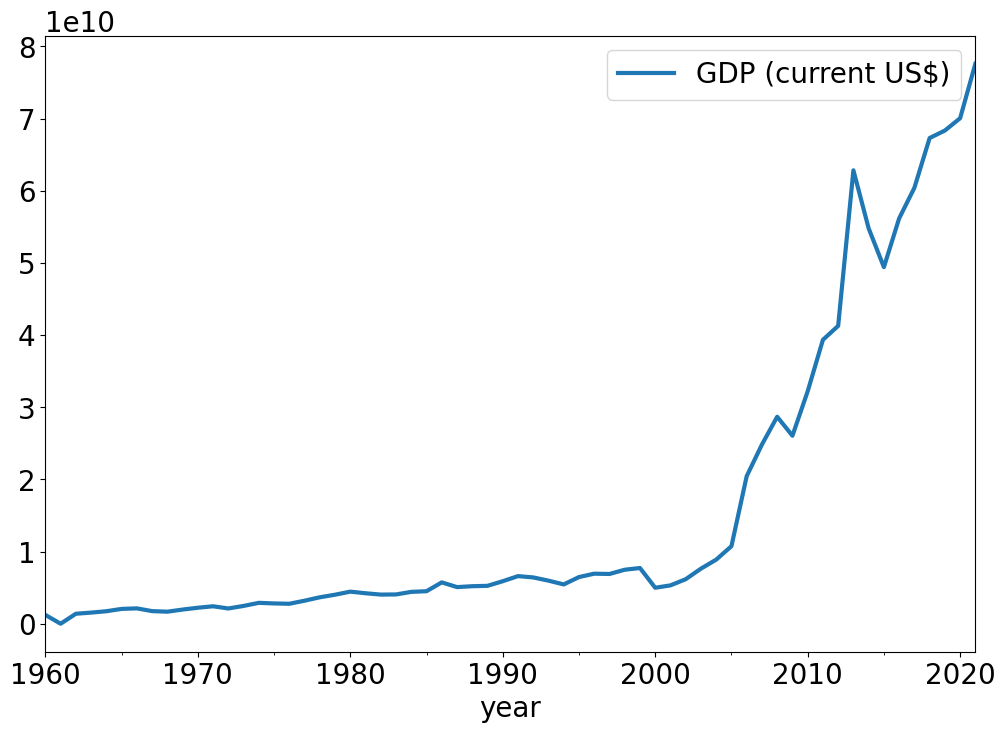

In [275]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [276]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

Сделаем декомпозицию временного ряда:

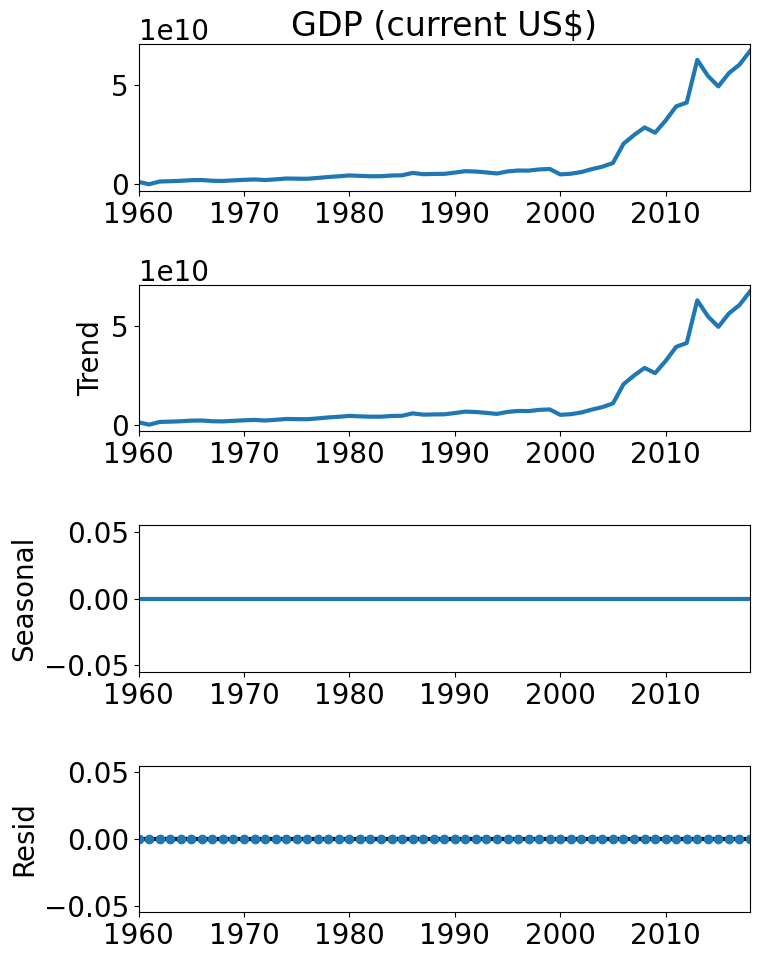

In [277]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 8, 10

result = seasonal_decompose(train_df['GDP (current US$)'])
result.plot()
plt.show()

Сезонная компонента и дисперсия равна нулю, график тренда повторяет график исходного ряда.

Визуализируем исходный временной ряд и построенный с помощью скользящего среднего:

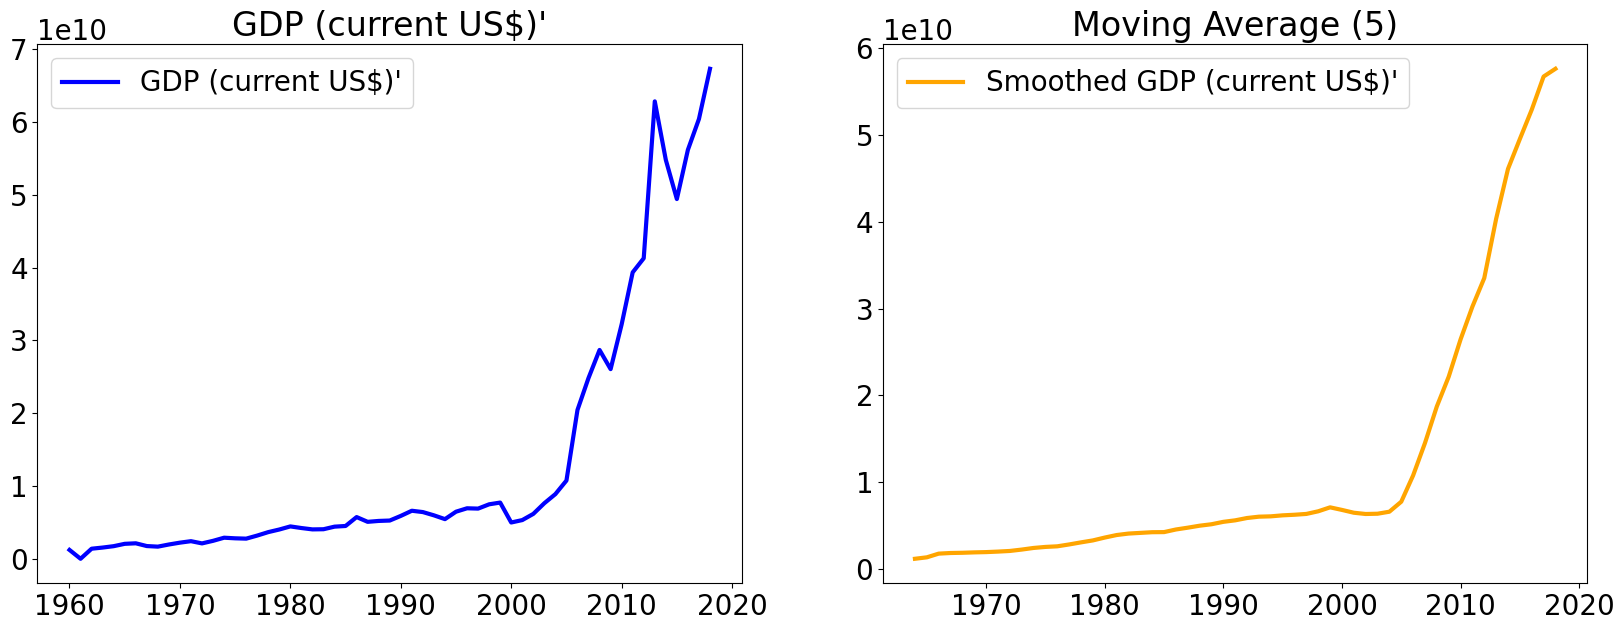

In [278]:
plt.rcParams["figure.figsize"] = 20, 7

fig, ax = plt.subplots(1, 2)


ax[0].plot(train_df['GDP (current US$)'], color="blue", label="GDP (current US$)'")
ax[0].set_title("GDP (current US$)'", size=24)
ax[0].legend()

ax[1].plot(
    train_df['GDP (current US$)'].rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP (current US$)'",
)

ax[1].set_title("Moving Average (5)", size=24)
ax[1].legend()

plt.show()

Еще раз убеждаемся, что тренд положительный с увеличением темпа роста после 2005 года. Графики рядов, построенные с помощью скользящего среднего похожи на график исходного ряда.

Автокорреляция:

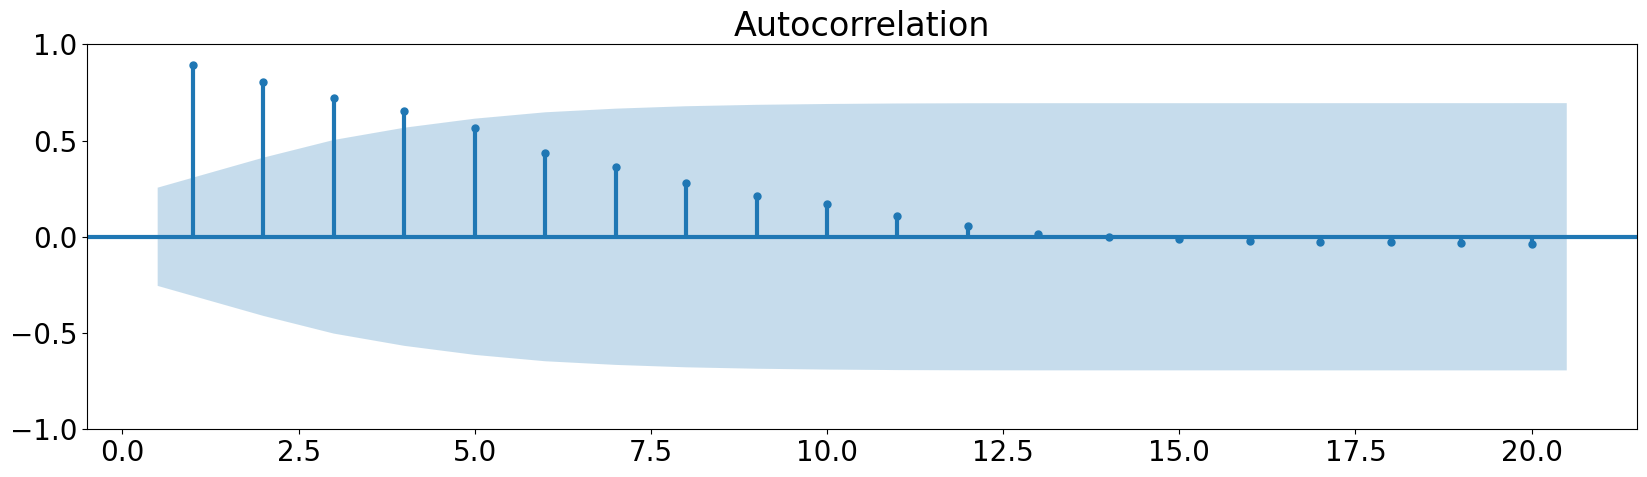

In [279]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df['GDP (current US$)'], lags=20, zero=False)
plt.show()

Корреляция сохраняется до 12 лага.

Частичная автокорреляция:

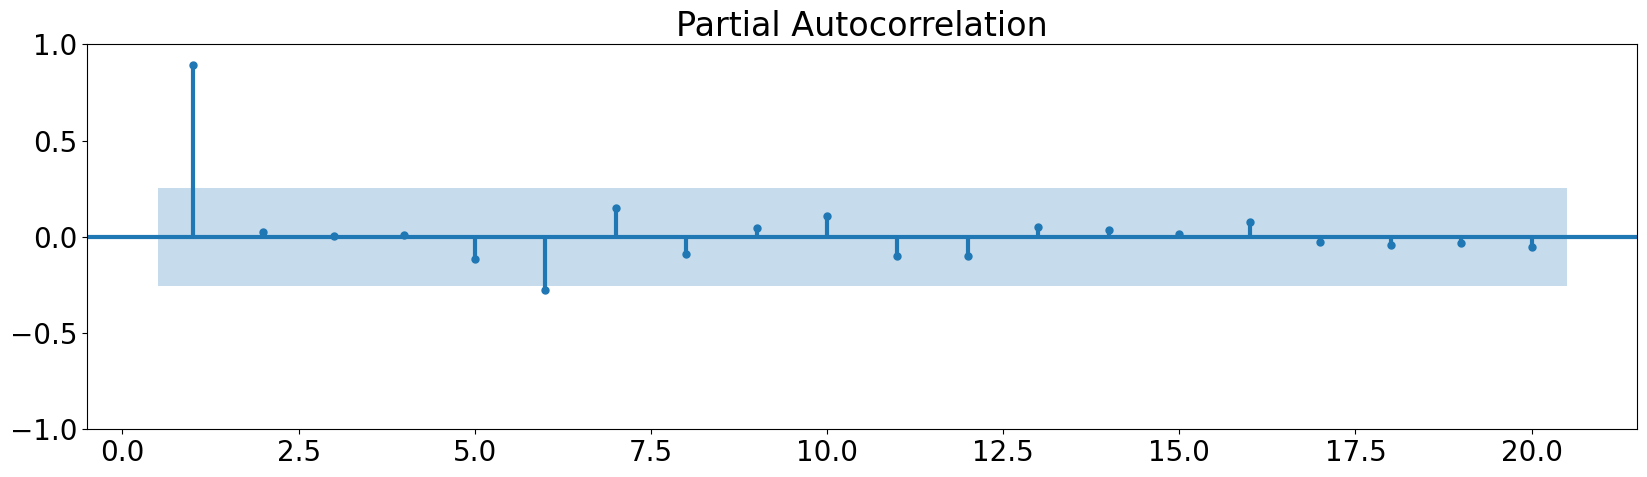

In [280]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df['GDP (current US$)'], lags=20, method="ywm", zero=False)
plt.show()

В отличие от того, что предлагали графики ACF,  уровень GDP с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается = 1.

Проведем тест на стационарность:

In [281]:
from statsmodels.tsa.stattools import adfuller

def df_test(data):
    test_1 = adfuller(data)
    print("adf: ", test_1[0])
    print("p-value: ", test_1[1])
    print("Critical values: ", test_1[4])
    if test_1[0] > test_1[4]["5%"]:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

df_test(train_df['GDP (current US$)'])


adf:  0.6529066974885405
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where,
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

In [282]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=12)
    sgt.plot_pacf(series, ax=axes[1], lags=12, method="ywm")
    plt.show()

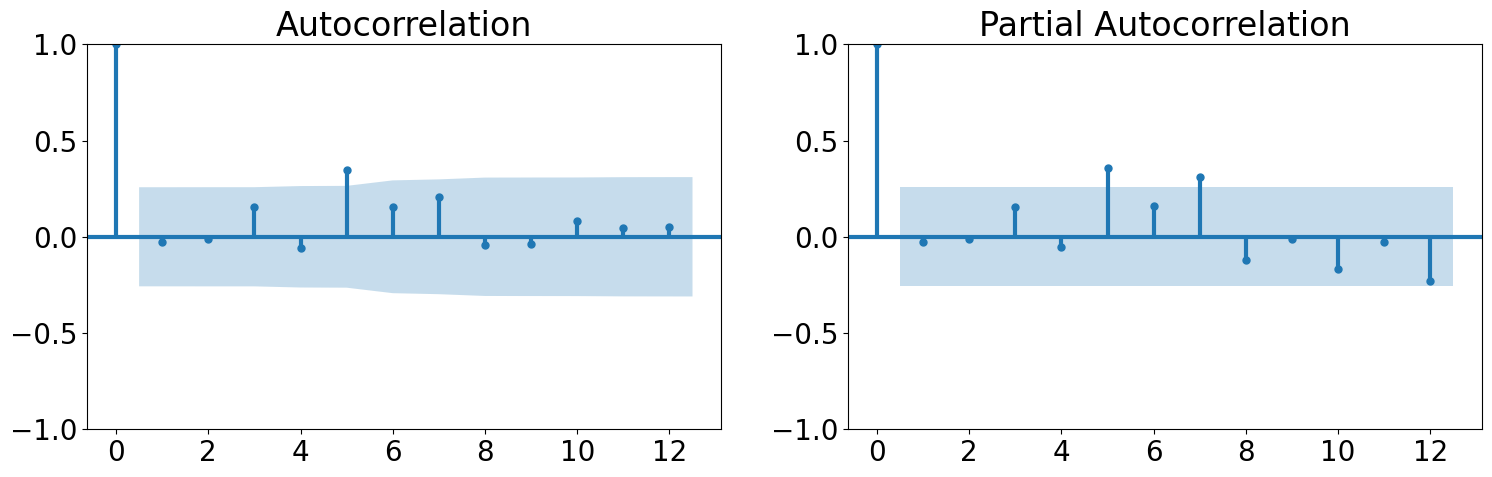

adf:  -1.670248303832082
p-value:  0.44650293297138693
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Ряд нестационарен


In [283]:
plot_acf_pacf(train_df['GDP (current US$)'].diff().dropna())

diff_1 = train_df['GDP (current US$)'].diff().dropna()

df_test(diff_1)

Принимаем p и q = 1.

Первые разности являются нестационарными

In [284]:
diff_2 = diff_1.diff().dropna()

df_test(diff_2)

adf:  -2.6408690561284924
p-value:  0.08484116917837625
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд нестационарен


Разности второго порядка являются нестационарными

In [285]:
diff_3 = diff_2.diff().dropna()

df_test(diff_3)

adf:  -4.779623784828569
p-value:  5.948327640223947e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд стационарен


Разности третьего порядка уже являются стационарными, принимем d = 3.

**PMDARIMA**

Начнем построение модели **PMDARIMA**:

In [287]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=12,
    max_q=3,
    D=1,
    start_P=0,
    seasonal=False,
    # m=50,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.08 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.04 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.05 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.10 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.06 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.09 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.12 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.15 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 2.243 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 30 Jun 2023   AIC                           2659.231
Time:                        19:49:02   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

Наилучшие параметры:
p = 2,
d = 3,
q = 1

**ARIMA**

Найденные ранее параметры:
- p = 1
- d = 3
- q = 1

In [288]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 1)   Log Likelihood               -1332.455
Date:                Fri, 30 Jun 2023   AIC                           2670.910
Time:                        19:49:02   BIC                           2676.986
Sample:                    01-01-1960   HQIC                          2673.266
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5073      0.091     -5.600      0.000      -0.685      -0.330
ma.L1         -0.9751      0.132     -7.380      0.000      -1.234      -0.716
sigma2      4.066e+19   1.88e-21   2.17e+40      0.000    4.07e+19    4.07e+19
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):               140.21
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):             441.28   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.73e+55. Standard errors may be unstable.
"""

Автоматический поиск параметров показал лучший результат.

Построим графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза:

In [289]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = smodel.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP (current US$)'] = data['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df['lower GDP (current US$)']
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']

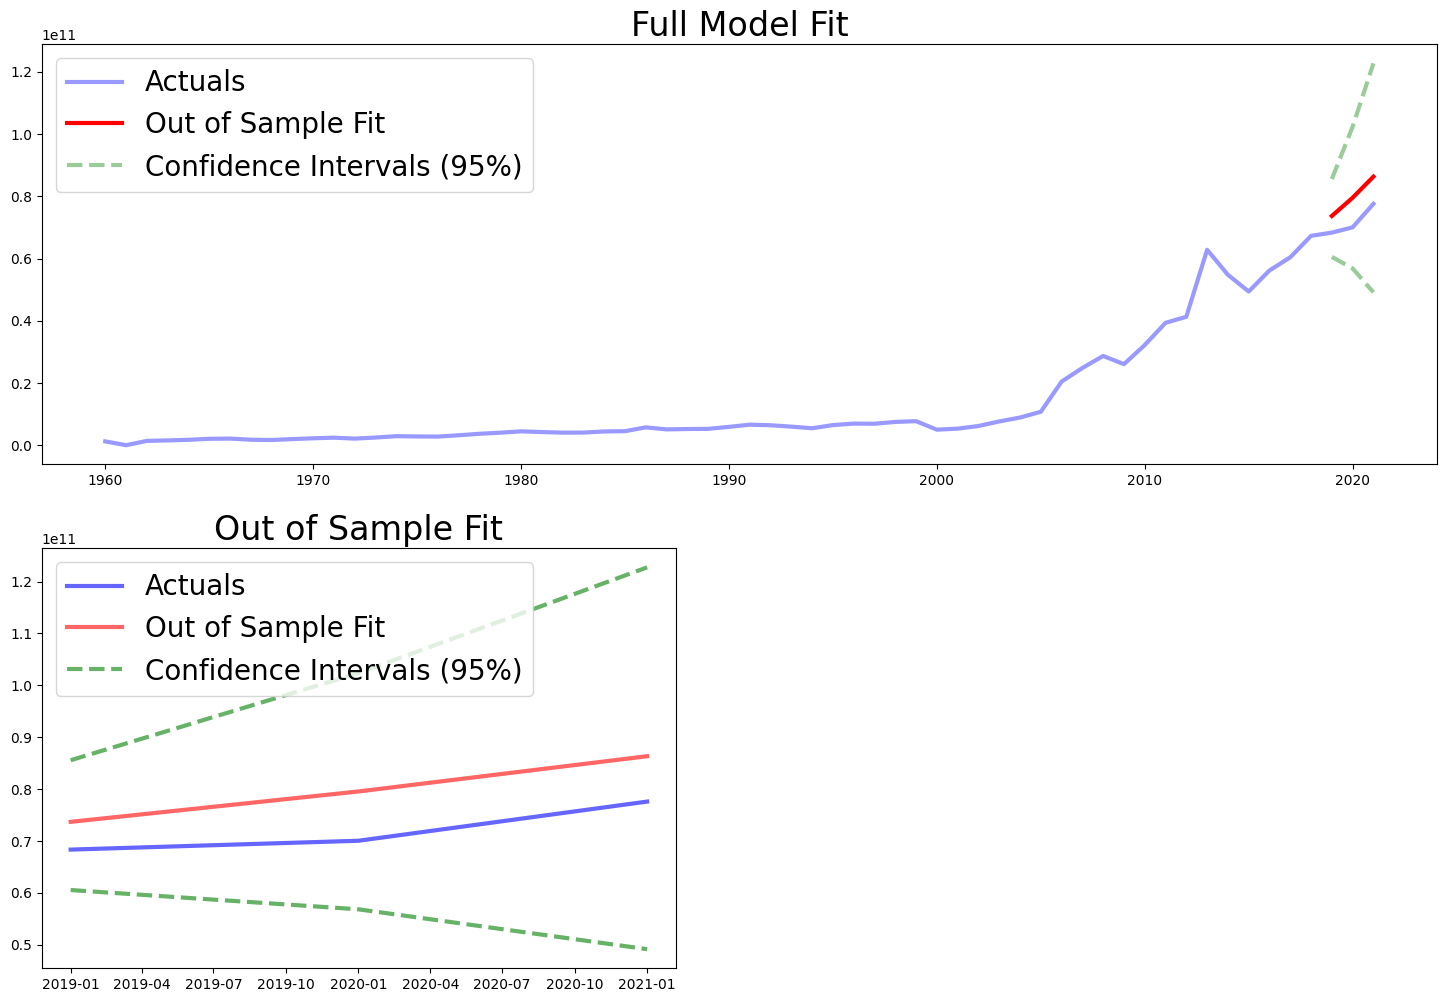

In [290]:
plt.rcParams["figure.figsize"] = 18, 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()



plt.show()

Предсказанный уровень GDP визуально продлевает предыдущую линию роста.

## Downsampling / Upsampling / Интерполяция

Проверим данные на наличие пропущенных дат:

In [291]:
data_asfreq = data.asfreq(freq='YS')

Проверим данные на наличие пропущенных значений:

In [292]:
data_asfreq.isna().sum()

GDP (current US$)    0
dtype: int64

Сделаем проверку на наличие нулевых значений и в случае нахождения заменим их на NaN.

In [293]:
import numpy as np

data_asfreq['GDP (current US$)'] = data_asfreq['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)


Выполним интерполяцию с использованием метода .interpolate():

In [294]:
int_data = data_asfreq['GDP (current US$)'].interpolate(method='linear')

Визуализируем полученный временной ряд:

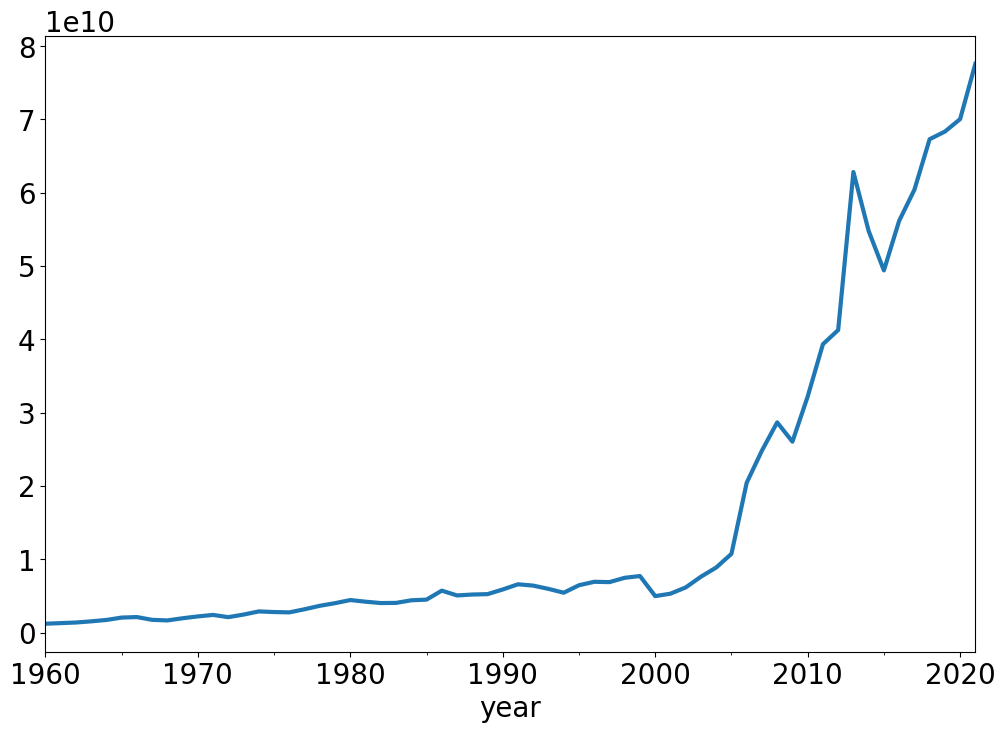

In [295]:
plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["lines.linewidth"] = 3

int_data.plot()
plt.show()

Проверим полученный ряд на стационарность:

In [296]:
df_test(int_data)

adf:  2.3808487575556314
p-value:  0.99900101016983
Critical values:  {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
Ряд нестационарен


In [297]:
diff_1 = int_data.diff().dropna()
df_test(diff_1)

adf:  -1.739718489292154
p-value:  0.41077316906677397
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд нестационарен


In [298]:
diff_2 = diff_1.diff().dropna()
df_test(diff_2)

adf:  -1.7042548913504167
p-value:  0.42892157301176387
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд нестационарен


In [299]:
diff_3 = diff_2.diff().dropna()
df_test(diff_3)

adf:  -5.456208629828514
p-value:  2.578324497203478e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд стационарен


Для получения стационарного ряда потребовалось диффиринцирование до 3-го порядка. Принимаем d = 3.

Построим графики автокорреляции и частичной корреляции:

In [300]:
train_df = int_data.iloc[:-3]
test_df = int_data.iloc[-3:]
train_df.shape, test_df.shape

((59,), (3,))

Графики обучающего ряда:

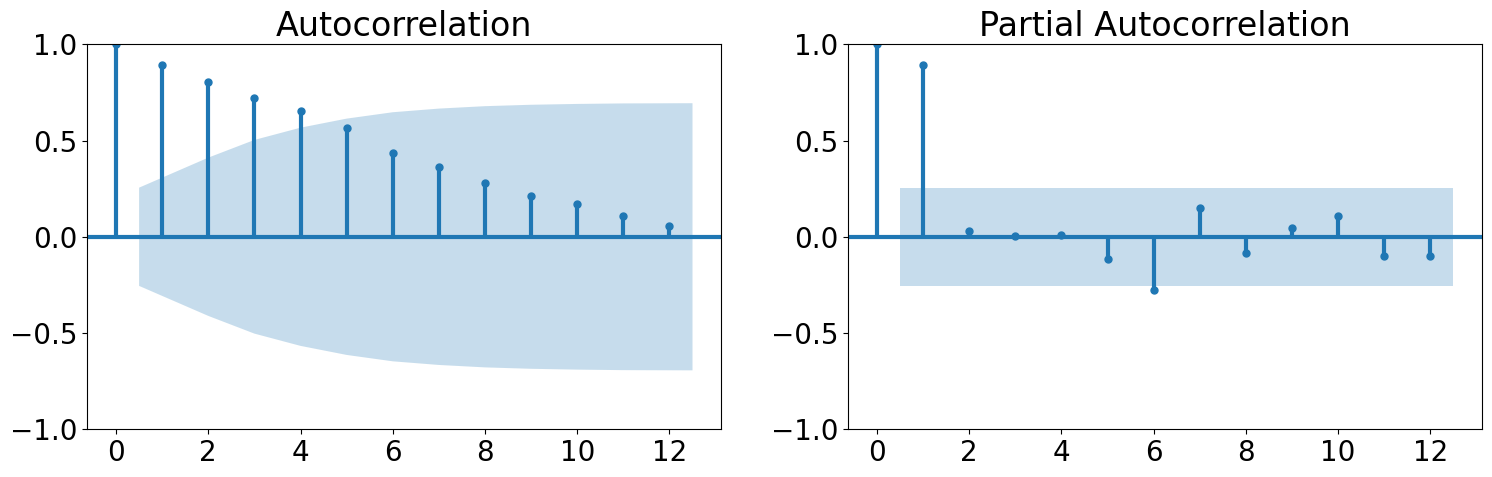

In [301]:
plot_acf_pacf(train_df)

Построим графики обучающего ряда после диффиренцирования:

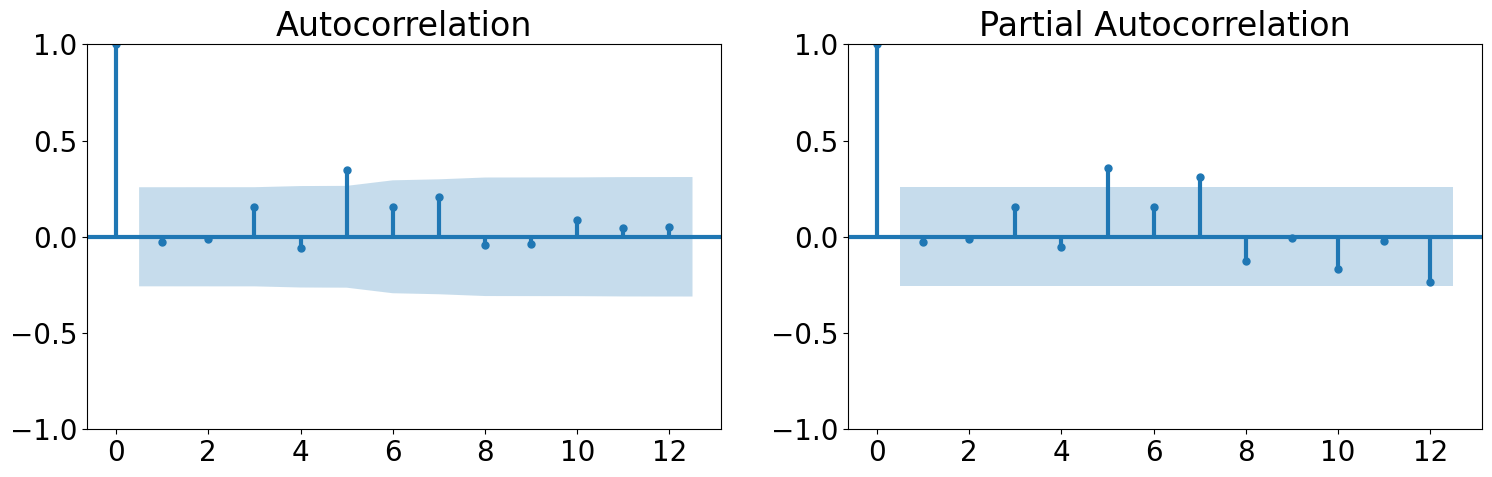

In [302]:
plot_acf_pacf(train_df.diff().dropna())

На дифферинцированных данных автокорреляция и частичная автокорреляция резко падает уже на 1-м лаге. Принимаем p = 1, q = 1.

**ARIMA**

In [303]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df.dropna(), order=(1, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 1)   Log Likelihood               -1332.466
Date:                Fri, 30 Jun 2023   AIC                           2670.933
Time:                        19:49:05   BIC                           2677.009
Sample:                    01-01-1960   HQIC                          2673.289
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5077      0.091     -5.602      0.000      -0.685      -0.330
ma.L1         -0.9750      0.132     -7.378      0.000      -1.234      -0.716
sigma2      4.072e+19   1.87e-21   2.18e+40      0.000    4.07e+19    4.07e+19
===================================================================================
Ljung-Box (L1) (Q):                   3.35   Jarque-Bera (JB):               140.71
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):             539.85   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.73e+55. Standard errors may be unstable.
"""

Попробуем подобрать лучшие параметры при помощи PMDARIMA:

In [304]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=12,
    max_q=3,
    D=1,
    start_P=0,
    seasonal=False,
    # m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.08 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.08 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.07 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.03 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.11 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.06 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.06 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.290 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Fri, 30 Jun 2023   AIC                           2659.226
Time:                        19:49:07   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.29e+56. Standard errors may be unstable.
"""

Автоматический поиск параметров показал лучший результат.

Построим графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза:

In [305]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = smodel.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP (current US$)'] = data['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df['lower GDP (current US$)']
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']

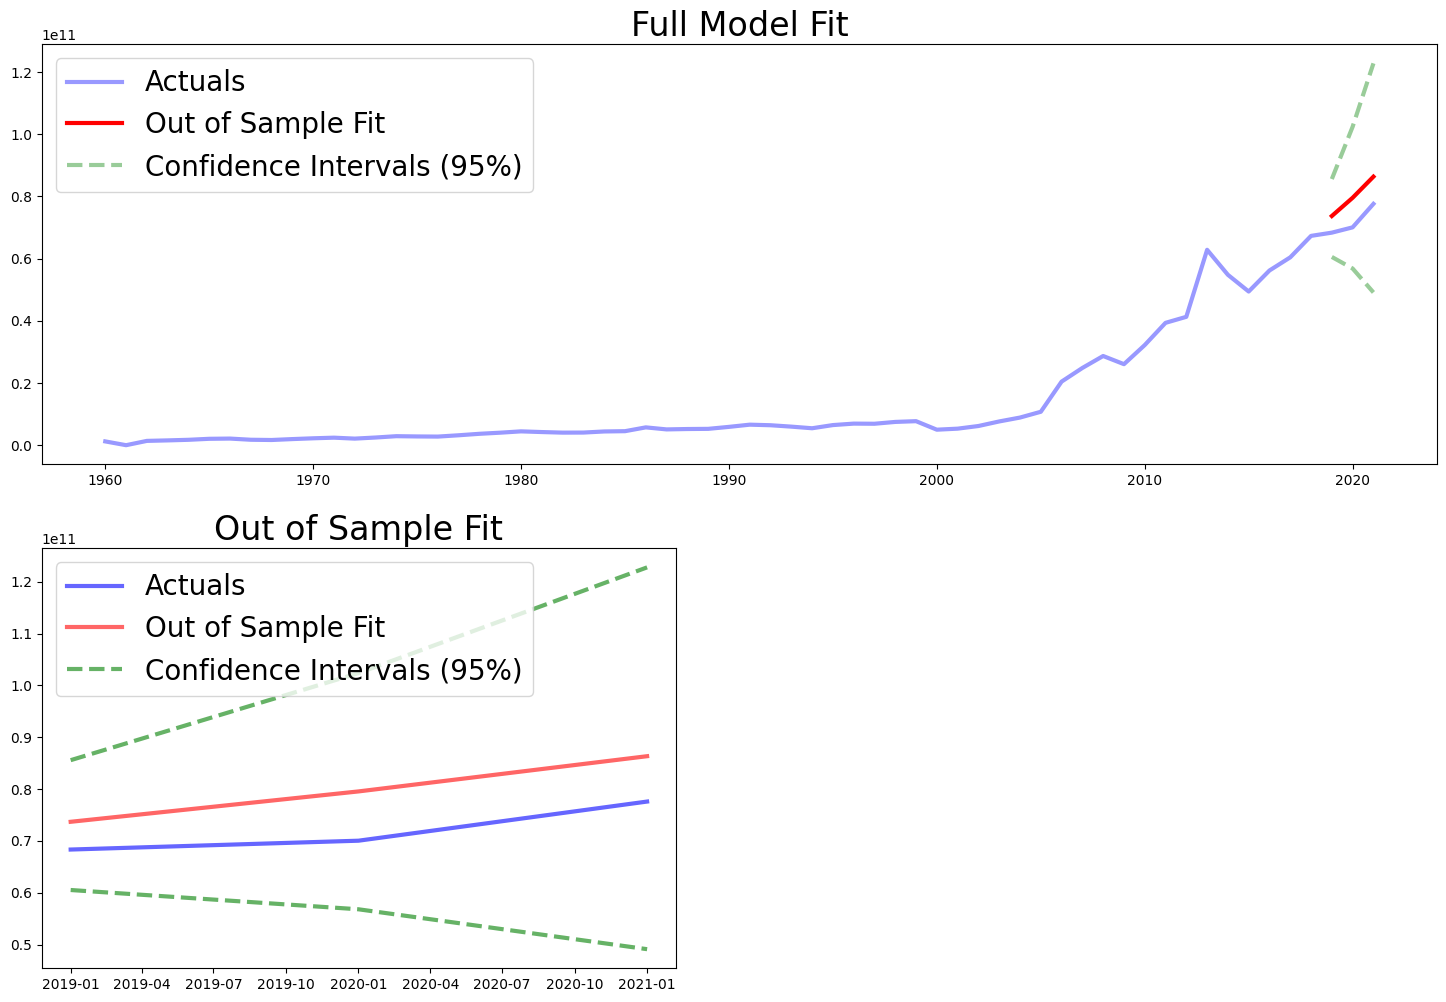

In [306]:
plt.rcParams["figure.figsize"] = 18, 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()



plt.show()

Предсказание на интеполированных данных показало такой же результат, как на исходных, есть незначительное снижение AIC.

## Волатильность

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

Посчитаем волатильность для нашего ряда:

In [308]:
int_data = pd.DataFrame(int_data)

int_data["gdp_vol"] = int_data.pct_change(1).mul(100).abs()
int_data.head()

,GDP (current US$),gdp_vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636


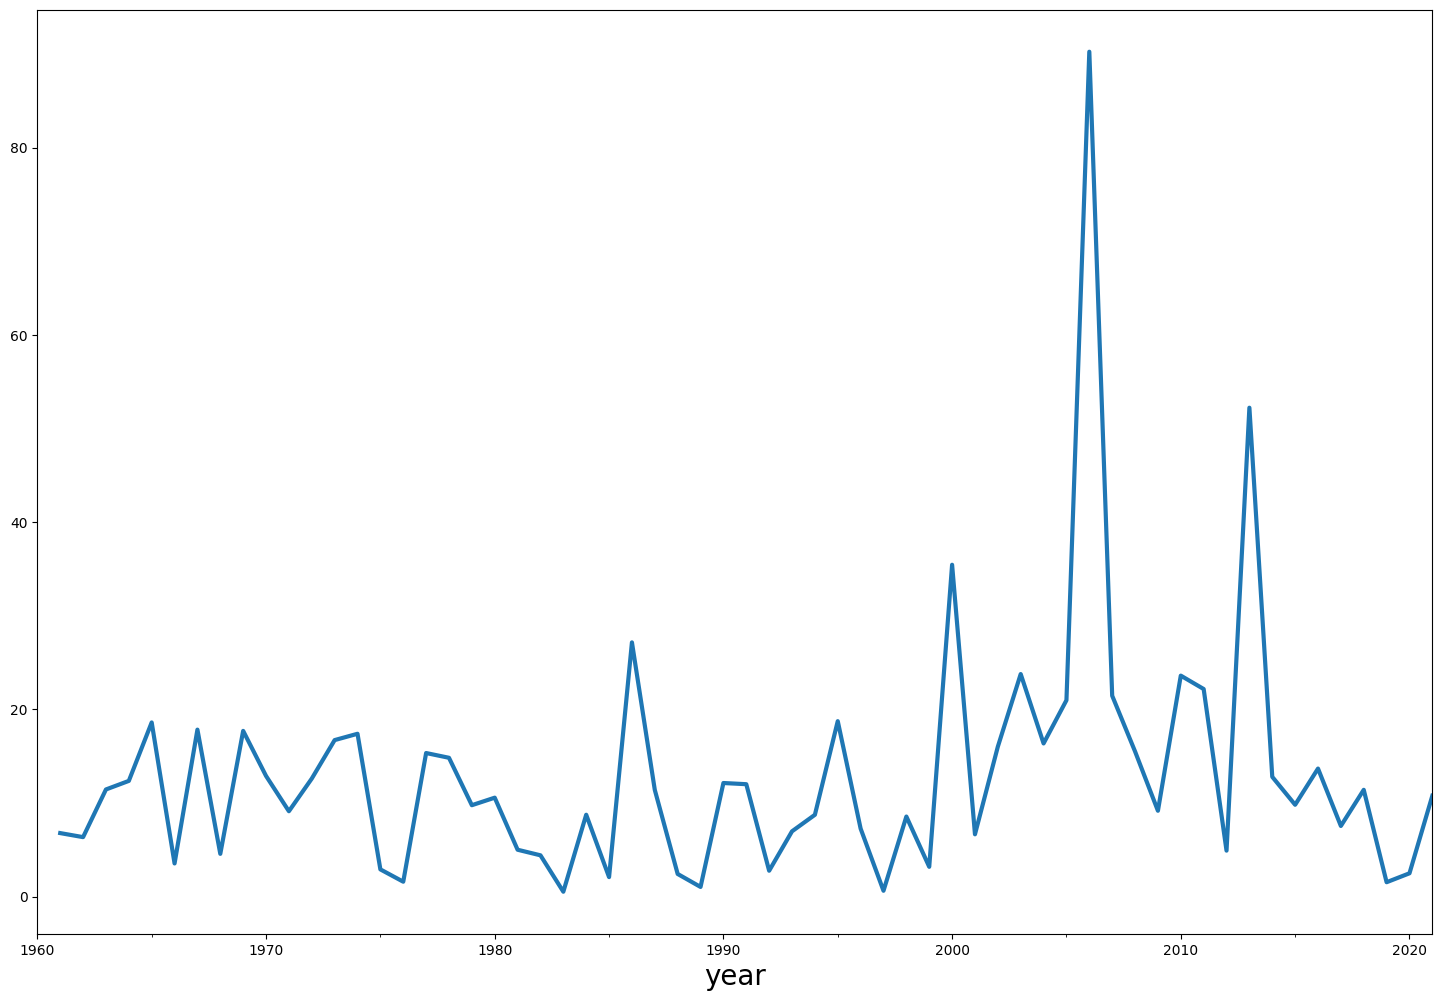

In [309]:
int_data.gdp_vol.plot()
plt.show()

Используем GARCH-модель для предсказания волатильности:

In [310]:
train_df = int_data.iloc[:-3].dropna()
test_df = int_data.iloc[-3:].dropna()
train_df.shape, test_df.shape

((58, 2), (3, 2))

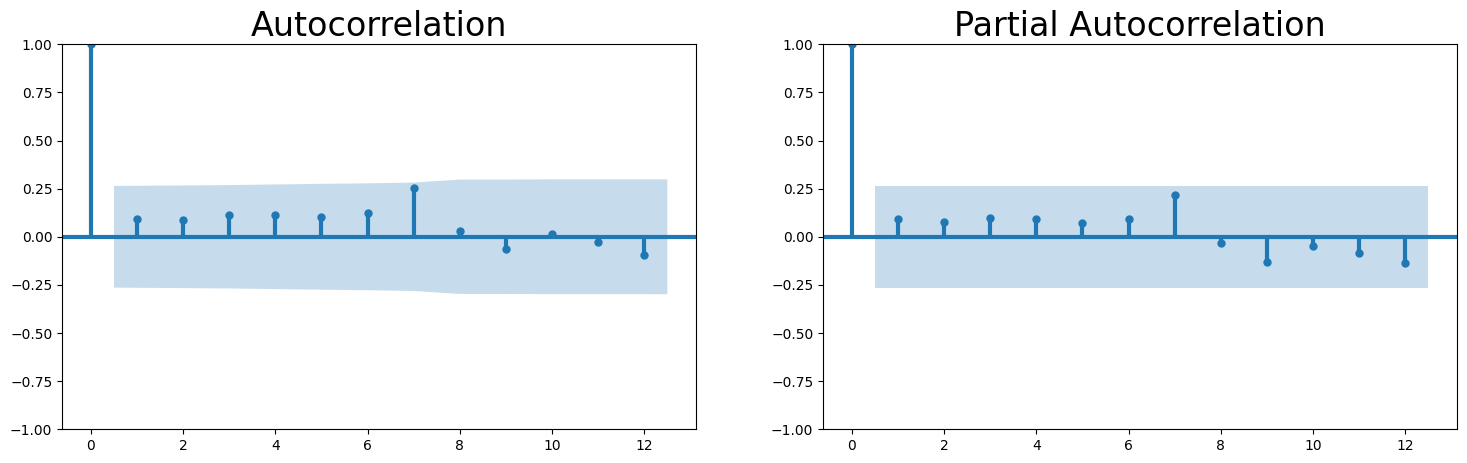

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
Ряд стационарен


In [311]:
plot_acf_pacf(train_df.gdp_vol[3:])
df_test(train_df["gdp_vol"])

На обоих кореллограммах самым информативным числом лагов являются 7, принимаем p, q =7.

In [312]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(int_data["gdp_vol"].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "gdp_vol"] = train_df["gdp_vol"].dropna()

In [313]:
garch_df

,gdp_vol
year,
1960-01-01,NaN
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636
...,...
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746


In [315]:
from arch import arch_model

model = arch_model(garch_df["gdp_vol"].dropna(), p=7, q=7)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40871495512866
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10079395318482
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01143994526097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00780231871062
            Iterations: 29
            Function evaluations: 492
            Gradient evaluations: 28


In [316]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.016
Method:            Maximum Likelihood   BIC:                           492.983
                                        No. Observations:                   58
Date:                Fri, Jun 30 2023   Df Residuals:                       57
Time:                        19:49:14   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

In [317]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Построим графики истинного и предсказанного поведения временного ряда:

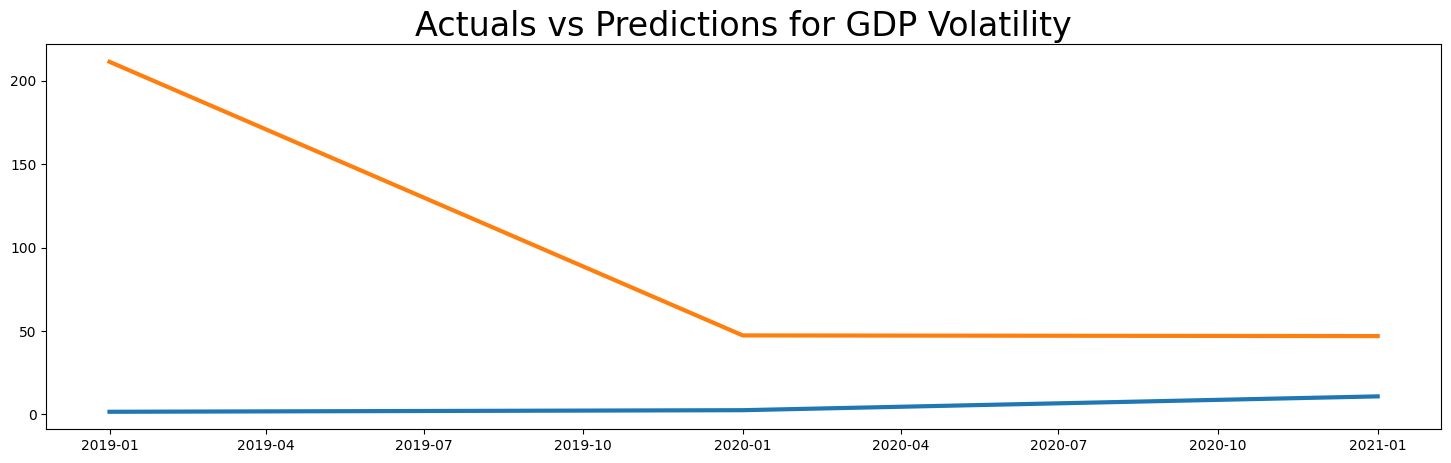

In [319]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["gdp_vol"])
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show()

In [320]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predictions_df["gdp_vol"].abs(), predictions_df["Predictions"]
)

15799.81566534356

Используем линейную регрессию для получения прогноза:

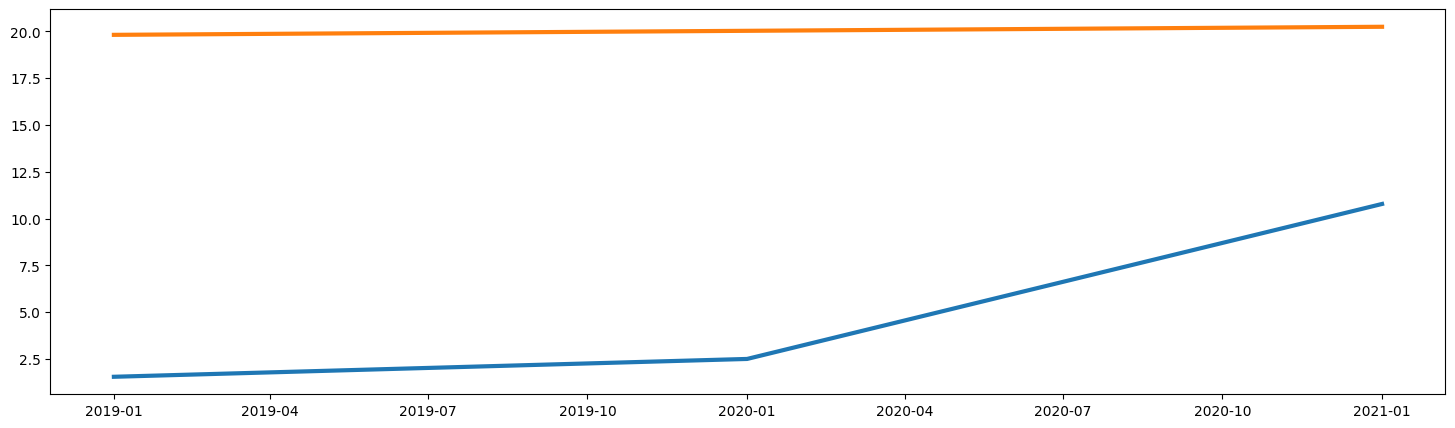

In [321]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(int_data["gdp_vol"].dropna().shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(int_data["gdp_vol"].dropna().shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

In [326]:
mean_squared_error(
    lr_predict, y_test
)

243.78726376950712

Линейная регрессия дала гораздо более точный результат.

Оба предсказания далеки от реальности, поскольку в первоначальном ряде дисперсия практически равна нулю и ряд имеет мало данных.